In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.ndimage import gaussian_filter1d
from scipy import stats

In [3]:
sns.set_style('ticks')
sns.set_context('talk')

In [4]:
data_dir = '/home/julia/data/ict/'

In [5]:
import warnings; warnings.simplefilter('ignore')

## Plot licking data aligned to odor start

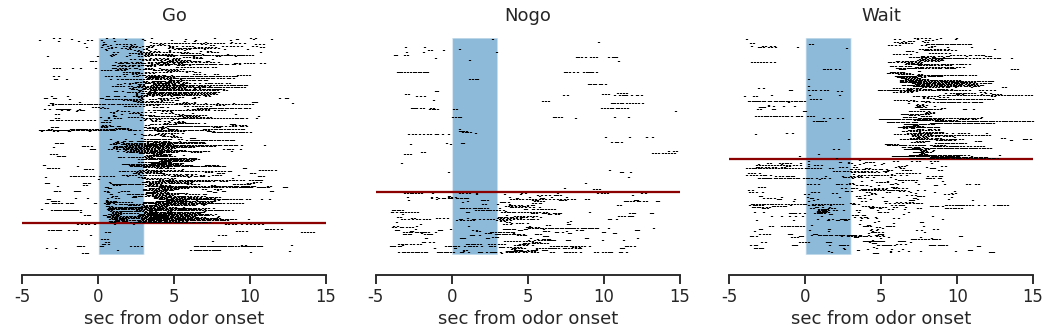

In [9]:
fig=plt.figure(figsize=(15,5))
subplot = 1

df = pd.read_csv(data_dir+"all_mice.csv", usecols=['type', 'performance'])
licks_all =  np.load(data_dir+"odor_aligned/all_licks.npy")

for c in ['go', 'nogo', 'wait']:

    # Add a new subplot for each condition
    fig.add_subplot(1,3,subplot)
    subplot += 1

    # get indices of trials with condition c and performance 0 / 1
    id_0 = df[(df['type']==c) & (df["performance"]==0)].index
    id_1 = df[(df['type']==c) & (df["performance"]==1)].index

    # Load lick data from those trials
    licks_0 = licks_all[:,id_0]
    licks_1 = licks_all[:,id_1]
    
    # Mark odor and trace period
    plt.fill_between(np.arange(0,3000,1),3000*[licks_0.shape[1]+licks_1.shape[1]], alpha=0.5)
    
    # Set index for y axis to zero
    idx=0 
    
    for trial in range(licks_0.shape[1]):
        plt.vlines(np.where(licks_0[:,trial]==1)[0]-5000, idx+1, idx+2)
        idx+=1
    plt.hlines(idx, -5000, 15000, color="darkred")
    
    for trial in range(licks_1.shape[1]):
        plt.vlines(np.where(licks_1[:,trial]==1)[0]-5000, idx+1, idx+2)
        idx+=1
            
    plt.xlabel("sec from odor onset")
    plt.xticks([-5000, 0, 5000, 10000, 15000], [-5, 0, 5, 10, 15])
    plt.yticks([])
    plt.title(c.capitalize())

    sns.despine(left=True, offset=10, trim=True)
    plt.tight_layout()

## Plot licking data aligned to ITI start

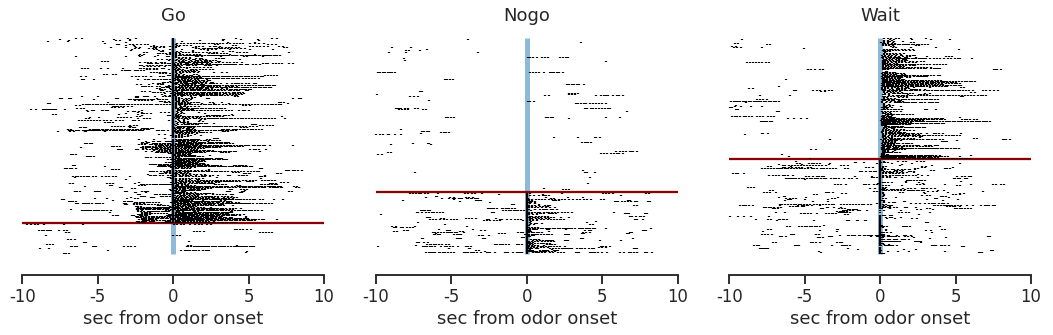

In [8]:
fig=plt.figure(figsize=(15,5))
subplot = 1

df = pd.read_csv(data_dir+"all_mice.csv", usecols=['type', 'performance'])
licks_all = np.load(data_dir+"iti_aligned/all_licks.npy")

for c in ['go', 'nogo', 'wait']:
    # Add a new subplot for each condition
    fig.add_subplot(1,3,subplot)
    subplot += 1
    
    # get indices of trials with condition c and performance 0 / 1
    id_0 = df[(df['type']==c) & (df["performance"]==0)].index
    id_1 = df[(df['type']==c) & (df["performance"]==1)].index

    # Load lick data from those trials
    licks_0 = licks_all[:,id_0]
    licks_1 = licks_all[:,id_1]
    
    plt.vlines(0, 0, licks_0.shape[1]+licks_1.shape[1], color="C0", linewidth=5, alpha=0.5)
    
    # Set index for y axis to zero
    idx=0 
    
    for trial in range(licks_0.shape[1]):
        plt.vlines(np.where(licks_0[:,trial]==1)[0]-10000, idx+1, idx+2)
        idx+=1
    plt.hlines(idx, -10000, 10000, color="darkred")
    
    for trial in range(licks_1.shape[1]):
        plt.vlines(np.where(licks_1[:,trial]==1)[0]-10000, idx+1, idx+2)
        idx+=1

    plt.xlabel("sec from odor onset")
    plt.xticks([-10000, -5000, 0, 5000, 10000], [-10, -5, 0, 5, 10])
    plt.yticks([])
    plt.title(c.capitalize())

sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()

## Plot only decision period

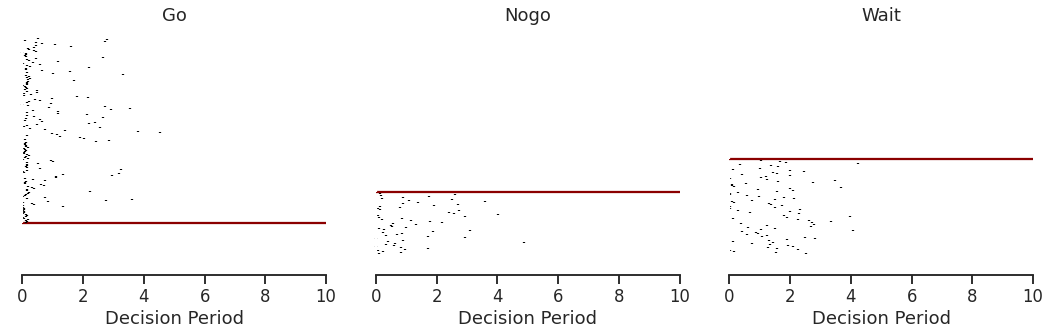

In [19]:
fig=plt.figure(figsize=(15,5))
subplot = 1

df = pd.read_csv(data_dir+"all_mice.csv", usecols=['type', 'performance', 'odor_start', 'iti_start'])
licks_all = np.load(data_dir+"odor_aligned/all_licks.npy")

for c in ['go', 'nogo', 'wait']:

    df_0 = df[(df['type']==c) & (df["performance"]==0)].filter(['odor_start', 'iti_start'])
    df_1 = df[(df['type']==c) & (df["performance"]==1)].filter(['odor_start', 'iti_start'])
    
    # Load lick data from those trials
    licks_0 = licks_all[:,df_0.index]
    licks_1 = licks_all[:,df_1.index]
    
    df_0 = df_0.reset_index(drop=True)
    df_1 = df_1.reset_index(drop=True)
    
    fig.add_subplot(1,3,subplot)
    subplot += 1
    
    idx=0 
    start = 5000 + 3000 # odor aligned data starts at -5000, odor 1000ms, trace 2000ms
    for row in range(len(df_0)):
        end = 5000 + (df_0.loc[row, 'iti_start'] - df_0.loc[row, 'odor_start']) # add the difference between odor start and iti start
        plt.vlines(np.where(licks_0[start:end+1,row]==1)[0], idx+1, idx+2) # increase end by one because of how python slices
        plt.vlines(0, idx+1, idx+2, color="white")
        idx+=1
    plt.hlines(idx, 0, 10000, color="darkred") 
    
    for row in range(len(df_1)):
        end = 5000 + (df_1.loc[row, 'iti_start'] - df_1.loc[row, 'odor_start']) # add the difference between odor start and iti start
        plt.vlines(np.where(licks_1[start:end+1,row]==1)[0], idx+1, idx+2)
        plt.vlines(0, idx+1, idx+2, color="white")
        idx+=1

    plt.xlabel("Decision Period")
    plt.xticks([0,2000,4000,6000,8000,10000], [0,2,4,6,8,10])
    plt.yticks([])
    plt.title(c.capitalize())

sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()

## Smooth lick rate with Gaussian filter (50ms sdv)

Licks acquired at 1kHz = 1000/sec = 1/ms
Therefore a SDV of 50 is 50 ms (?)

In [5]:
for a in ['odor', 'iti']:
    licks_all = np.load(data_dir+"{}_aligned/all_licks.npy".format(a))
    licks_smooth = gaussian_filter1d(licks_all, sigma=50, axis=0, output=np.float64)
    np.save(data_dir+"{}_aligned/all_licks_smooth_50.npy".format(a), licks_smooth)

## Lick rate across mice -- odor aligned

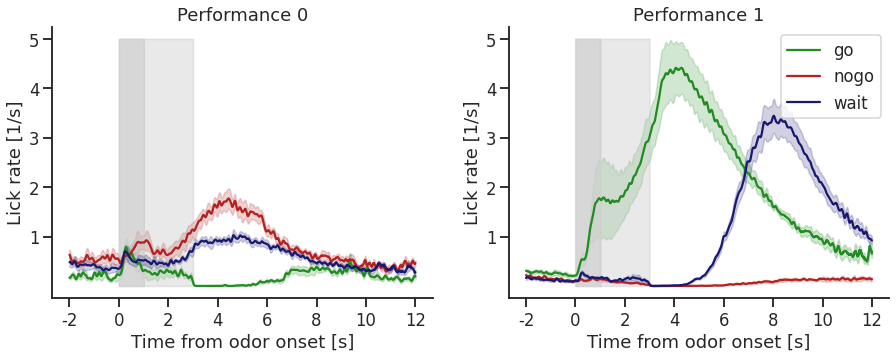

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

types = ['go', 'nogo', 'wait']
mice = ['SHA', 'TAY', 'UUU', 'VVV', 'WEY', 'YOU']
colors = ['forestgreen', 'firebrick', 'midnightblue']
performances = [0,1]


df = pd.read_csv(data_dir+"all_mice.csv", usecols=['dataset', 'type', 'performance'])
licks_all = np.load(data_dir+"odor_aligned/all_licks_smooth_50.npy")

for c in range(len(types)):
    for p in performances:
        
        L = np.zeros((licks_all.shape[0], len(mice)))
        for m in range(len(mice)):
            idcs = df[(df['type']==types[c]) & 
                      (df['performance']==p) & 
                      (df['dataset'].str.contains(mice[m]))].index
            L[:,m] = np.nanmean(licks_all[:,idcs], axis=1)

        x = np.arange(-2000, 12000)
        y = np.nanmean(L[3000:17000], axis=1)
        sem = stats.sem(L[3000:17000], axis=1, nan_policy='omit')

        ax[p].plot(x, y, color=colors[c], label="{}".format(types[c]))
        ax[p].fill_between(np.arange(0,1000), np.zeros(1000), np.ones(1000)*0.005, color='lightgrey', alpha=0.5)
        ax[p].fill_between(np.arange(1000,3000), np.zeros(2000), np.ones(2000)*0.005, color='lightgrey', alpha=0.2)
        ax[p].fill_between(x, (y-sem), (y+sem), color=colors[c], alpha=.2)
        ax[p].set_xticks([-2000, 0, 2000, 4000,6000,8000,10000,12000])
        ax[p].set_xticklabels([-2,0,2,4,6,8,10,12])
        ax[p].set_xlabel('Time from odor onset [s]')
        ax[p].set_yticks([0.001, 0.002, 0.003, 0.004, 0.005])
        ax[p].set_yticklabels([1,2,3,4, 5])
        ax[p].set_ylabel('Lick rate [1/s]')
        ax[p].set_title('Performance {}'.format(performances[p]))
        sns.despine()
        
    ax[p].legend()

## Lick rate across mice -- ITI aligned

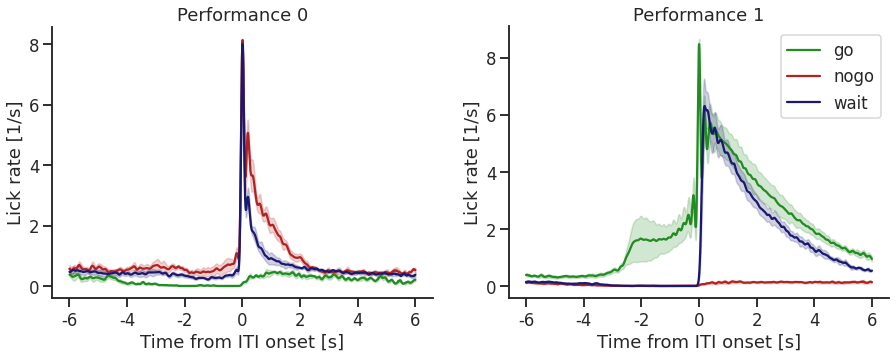

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

types = ['go', 'nogo', 'wait']
mice = ['SHA', 'TAY', 'UUU', 'VVV', 'WEY', 'YOU']
colors = ['forestgreen', 'firebrick', 'midnightblue']
performances = [0,1]


df = pd.read_csv(data_dir+"all_mice.csv", usecols=['dataset', 'type', 'performance'])
licks_all = np.load(data_dir+"iti_aligned/all_licks_smooth_50.npy")

for c in range(len(types)):
    for p in performances:
        
        L = np.zeros((licks_all.shape[0], len(mice)))
        for m in range(len(mice)):
            idcs = df[(df['type']==types[c]) & 
                      (df['performance']==p) & 
                      (df['dataset'].str.contains(mice[m]))].index
            L[:,m] = np.nanmean(licks_all[:,idcs], axis=1)

        x = np.arange(-6000, 6000)
        y = np.nanmean(L[4000:16000], axis=1)
        sem = stats.sem(L[4000:16000], axis=1, nan_policy='omit')

        ax[p].plot(x, y, color=colors[c], label="{}".format(types[c]))
        ax[p].fill_between(x, (y-sem), (y+sem), color=colors[c], alpha=.2)
        ax[p].set_xticks([-6000, -4000, -2000, 0, 2000, 4000, 6000])
        ax[p].set_xticklabels([-6,-4,-2,0,2,4,6])
        ax[p].set_xlabel('Time from ITI onset [s]')
        ax[p].set_yticks([0, 0.002, 0.004, 0.006, 0.008])
        ax[p].set_yticklabels([0,2,4,6,8])
        ax[p].set_ylabel('Lick rate [1/s]')
        ax[p].set_title('Performance {}'.format(performances[p]))
        sns.despine()
        
    ax[p].legend()

## Compare before and after reversal per odor

In [8]:
pal = sns.color_palette('twilight',30)[5:16]
pal_b = sns.color_palette('twilight_shifted',30)[-12:-2]
for i in pal_b:
    pal.append(i)

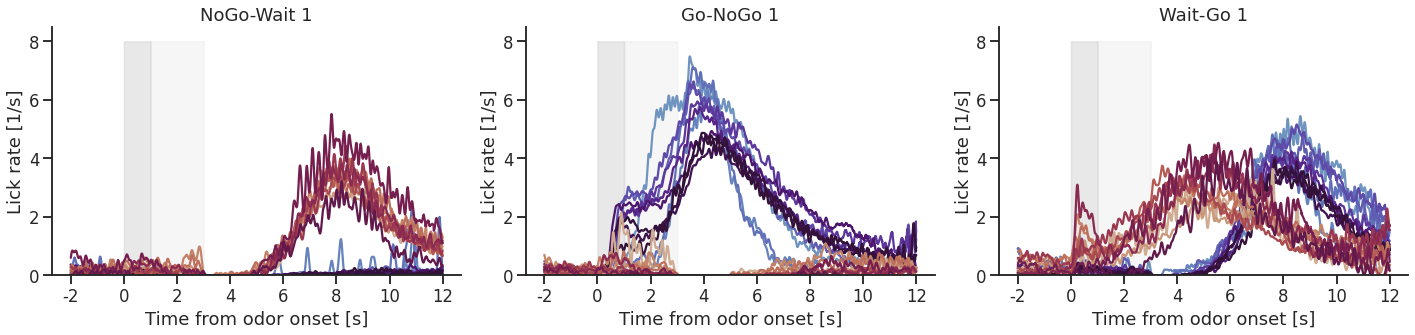

In [18]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
odors = [1,2,3]
odor_labels = ['NoGo-Wait', 'Go-NoGo', 'Wait-Go']
days = range(-11,10)
mice = ['SHA', 'TAY', 'UUU', 'VVV', 'WEY', 'YOU']
performances = [1]#[0,1]


df = pd.read_csv(data_dir+"all_mice.csv", usecols=['dataset', 'day', 'odor', 'performance'])
licks_all = np.load(data_dir+"odor_aligned/all_licks_smooth_50.npy")

for o in range(len(odors)):
    for p in performances:
        for d in range(len(days)):
            
            L = np.zeros((licks_all.shape[0], len(mice)))
            for m in range(len(mice)):
                idcs = df[(df['odor']==odors[o]) & 
                      (df['performance']==p) & 
                      (df['day']==days[d]) &    
                      (df['dataset'].str.contains(mice[m]))].index
                L[:,m] = np.nanmean(licks_all[:,idcs], axis=1)
        
            x = np.arange(-2000, 12000)
            y = np.nanmean(L[3000:17000], axis=1)
            ax[o].plot(x, y, color=pal[d], label=days[d])

        ax[o].fill_between(np.arange(0,1000), np.zeros(1000), np.ones(1000)*0.008, color='lightgrey', alpha=0.5)
        ax[o].fill_between(np.arange(1000,3000), np.zeros(2000), np.ones(2000)*0.008, color='lightgrey', alpha=0.2)
        ax[o].set_xticks([-2000, 0, 2000, 4000,6000,8000,10000,12000])
        ax[o].set_xticklabels([-2,0,2,4,6,8,10,12])
        ax[o].set_xlabel('Time from odor onset [s]')
        ax[o].set_yticks([0, 0.002, 0.004, 0.006, 0.008])
        ax[o].set_yticklabels([0,2,4,6,8])
        ax[o].set_ylim([0,0.0085])
        ax[o].set_ylabel('Lick rate [1/s]')
        ax[o].set_title('{} {}'.format(odor_labels[o], p))
        sns.despine()
        plt.tight_layout()

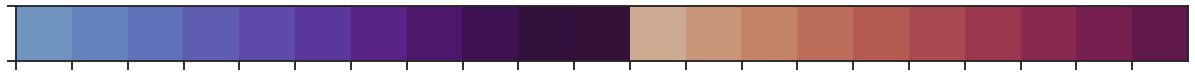

In [12]:
sns.palplot(pal)

## Average response per mouse, over days and per odor

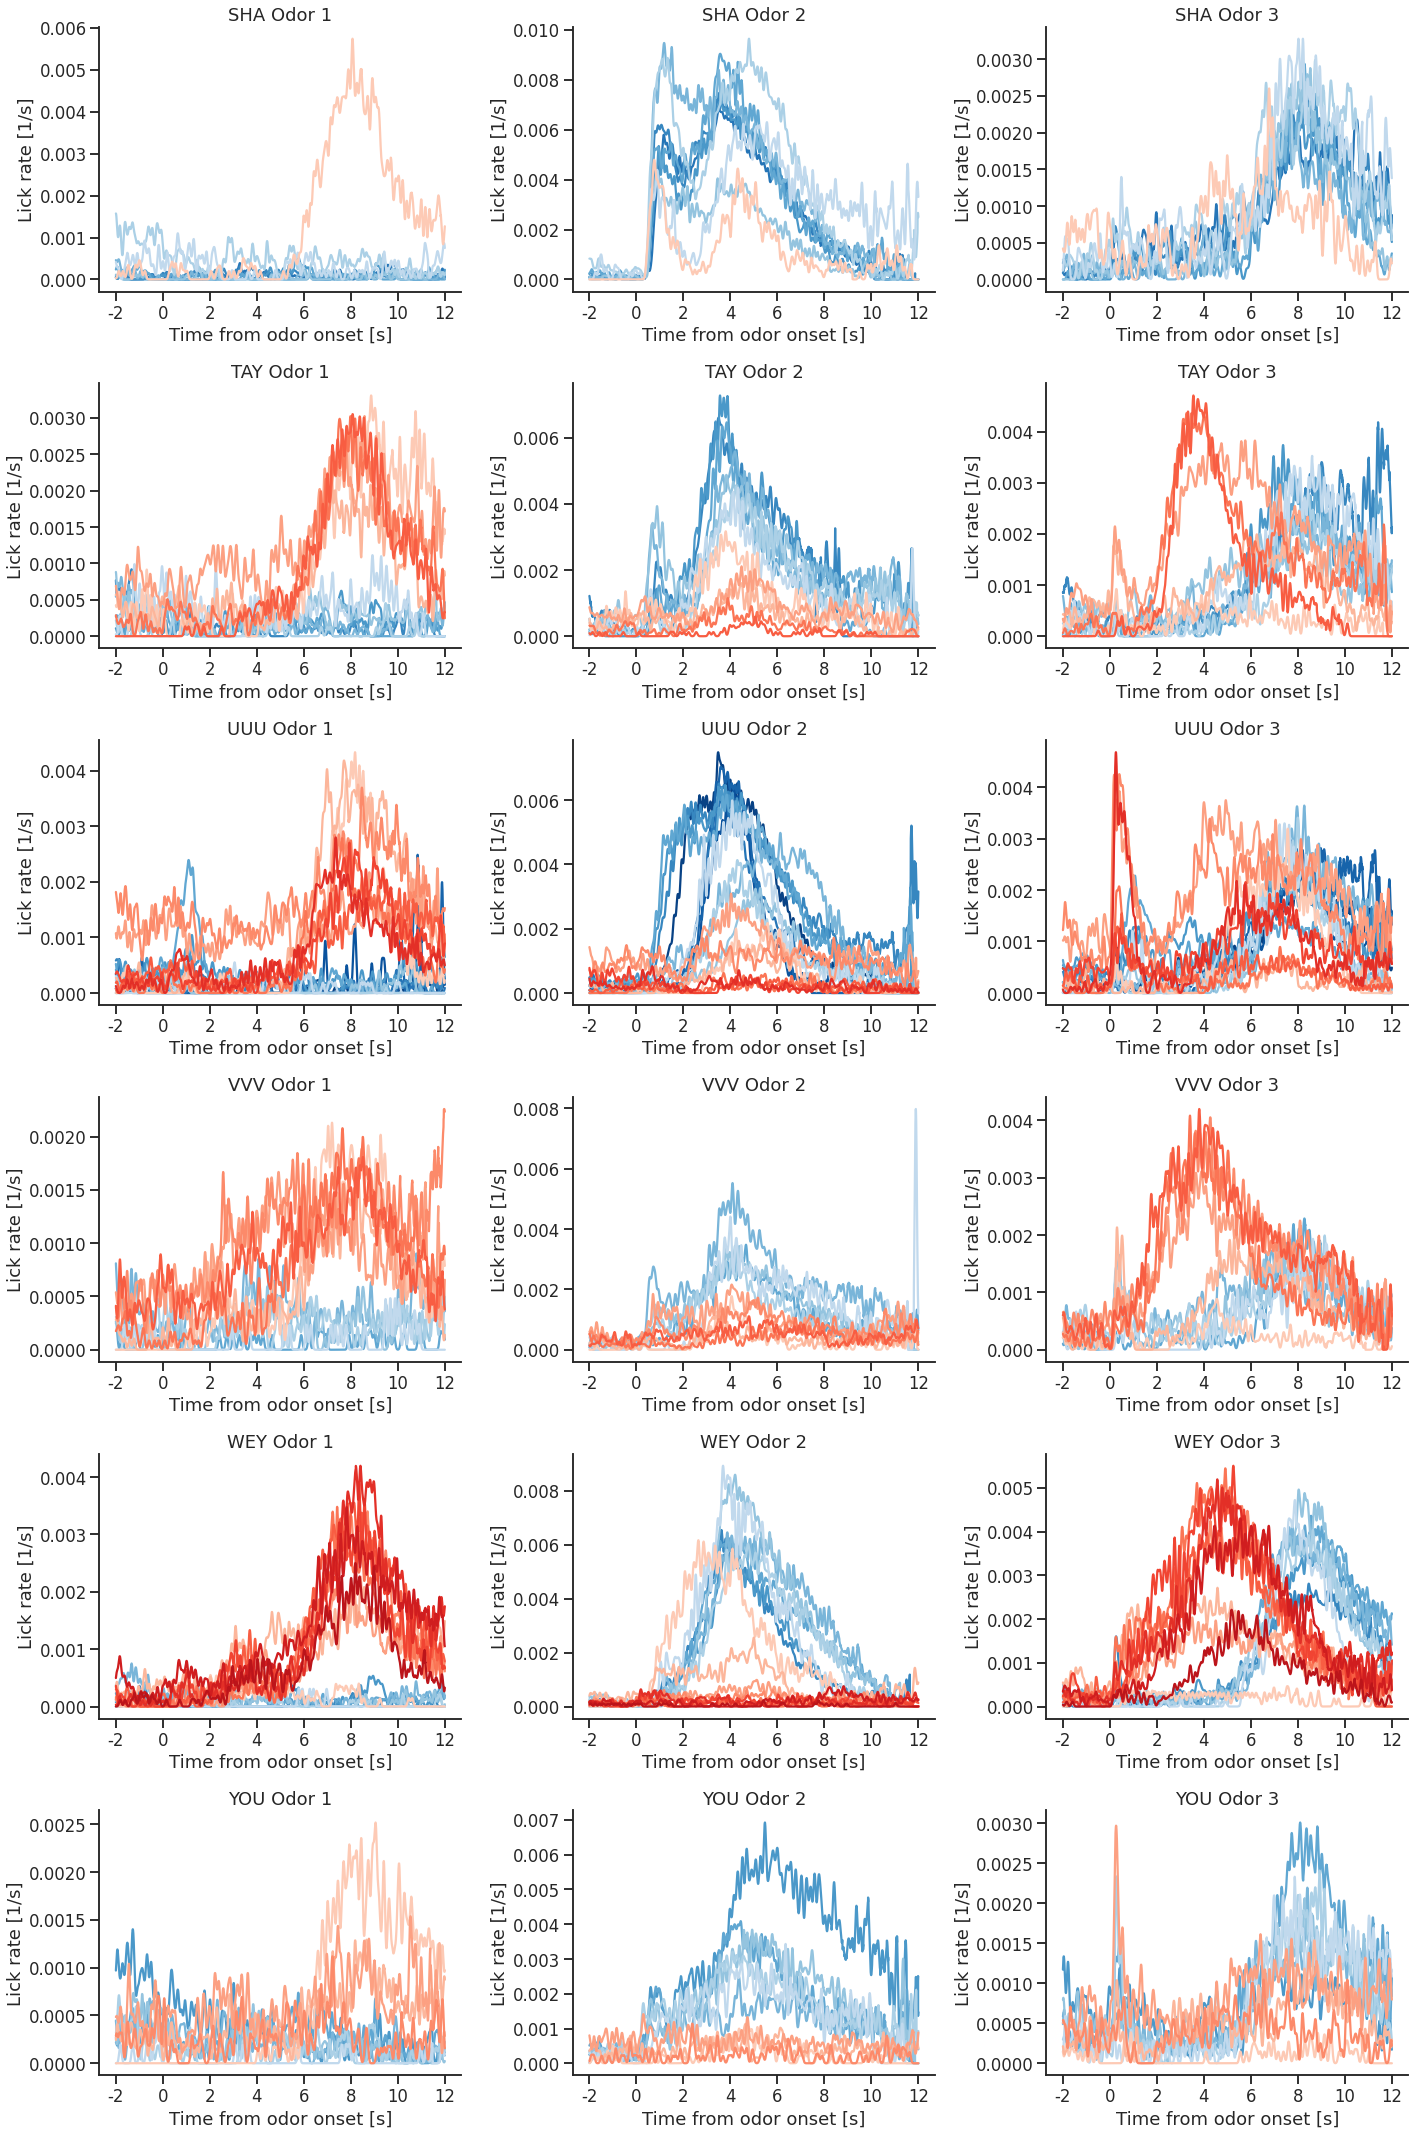

In [215]:
fig, ax = plt.subplots(6,3, figsize=(20,30))

neg_colors = sns.color_palette("Blues", 14)
pos_colors = sns.color_palette("Reds", 14)

odors = [1,2,3]
mice = ['SHA', 'TAY', 'UUU', 'VVV', 'WEY', 'YOU']

df = pd.read_csv(data_dir+"all_mice.csv", usecols=['dataset', 'day', 'odor'])
licks_all = np.load(data_dir+"odor_aligned/all_licks_smooth_50.npy")


for m in range(len(mice)):
    
    # find the range of days for this mouse
    days = range(df[df['dataset'].str.contains(mice[m])]['day'].min(), 
                 df[df['dataset'].str.contains(mice[m])]['day'].max()+1) 
    
    for o in range(len(odors)):
     
        for d in range(len(days)):
            
            idcs = df[(df['odor']==odors[o]) & 
                      (df['day']==days[d]) &    
                      (df['dataset'].str.contains(mice[m]))].index
            
            y = np.nanmean(licks_all[:,idcs][3000:17000], axis=1)
            x = np.arange(-2000, 12000)
            
            if days[d] < 0:
                color = neg_colors[np.abs(days[d])+2]
            else:
                color = pos_colors[days[d]+2]
                
            ax[m,o].plot(x, y, color=color)

        #ax[m,o].fill_between(np.arange(0,1000), np.zeros(1000), np.ones(1000)*0.008, color='lightgrey', alpha=0.5)
        #ax[m,o].fill_between(np.arange(1000,3000), np.zeros(2000), np.ones(2000)*0.008, color='lightgrey', alpha=0.2)
        ax[m,o].set_xticks([-2000, 0, 2000, 4000,6000,8000,10000,12000])
        ax[m,o].set_xticklabels([-2,0,2,4,6,8,10,12])
        ax[m,o].set_xlabel('Time from odor onset [s]')
        #ax[m,o].set_yticks([0, 0.002, 0.004, 0.006, 0.008])
        #ax[m,o].set_yticklabels([0,2,4,6,8])
        #ax[m,o].set_ylim([0,0.0085])
        ax[m,o].set_ylabel('Lick rate [1/s]')
        ax[m,o].set_title('{} Odor {}'.format(mice[m], odors[o]))
        sns.despine()
        plt.tight_layout()

### Decision lick rate over days

In [105]:
df = pd.read_csv(data_dir+"all_mice.csv", usecols=['dataset', 'day', 'performance', 'odor' ,'odor_start', 'iti_start'])
licks_all = np.load(data_dir+"odor_aligned/all_licks_smooth_50.npy")
odors = [1,2,3]
odor_labels = ['NoGo-Wait', 'Go-NoGo', 'Wait-Go']
mice = ['SHA','TAY', 'UUU', 'VVV', 'WEY', 'YOU']
days = [-3,-2,-1,0,1,2,3, 4, 5]

In [127]:
lick_rates = []
mouse_ids = []
odor_ids = []
day_ids = []
for d in range(len(days)):
    for o in range(len(odors)):
        for m in mice:
            lick_rate = []
            idcs = df[(df['day']==days[d]) &
                      (df['odor']==odors[o]) &
                      (df['dataset'].str.contains(m))].index
            for i in idcs:
                iti_start = 5000+df.loc[i,'iti_start']-df.loc[i,'odor_start']
                decision_licks = np.nanmean(licks_all[8000:iti_start+1,i])
                base_licks = np.nanmean(licks_all[4000:5000,i])
                lick_rate.append(decision_licks-base_licks)
            lick_rates.append(np.nanmean(lick_rate)*1000)
            mouse_ids.append(m)
            odor_ids.append(odor_labels[o])
            day_ids.append(days[d])

In [128]:
df_plot = pd.DataFrame(columns=['Mouse', 'Day', 'Odor', 'Lick Rate [1/s]'], 
                       data=zip(mouse_ids, day_ids, odor_ids, lick_rates))

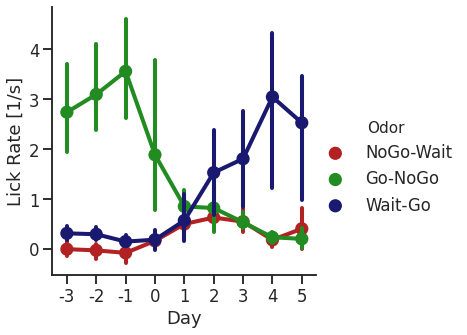

In [129]:
sns.catplot(x="Day", y="Lick Rate [1/s]", hue="Odor",
            kind="point", data=df_plot, palette=colors);